In [2]:
import numpy as np
%matplotlib inline
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.style.use('ggplot')
from sklearn import linear_model
plt.rcParams["figure.figsize"] = (10,10)
import math
import seaborn as sns


In [3]:
data = pd.read_csv('look.txt', sep=' ')

In [4]:
from glob import glob

In [5]:
glob("*")

['income',
 'phased_HGDP+India+Africa_1272SNPs-chr21-regions7to22.stru',
 'unphased_HGDP+India+Africa_517SNPs-chr21-regions7to22.stru',
 'number of samples.ipynb',
 'unphased_HGDP+India+Africa_2810SNPs-regions1to36.stru',
 'income_dataset.zip',
 'huangEtAl2011snpdata_readme',
 'genome vis.ipynb',
 'lookmenow.txt',
 'unphased_HGDP+India+Africa_1195SNPs-chr21-regions7to22.stru',
 'look.txt',
 'phased_HGDP+India+Africa_2810SNPs-regions1to36.stru',
 'look.tsv',
 'single cell ',
 'phased_HapMap3-release2_517SNPs-chr21-regions7to22.stru',
 'chr21_hapmap3.polaritySNP']

In [ ]:
data

In [31]:
data.describe()

,rs2192160,rs2822441,rs2822475,rs434396,rs2822510,rs417214,rs2822518,rs2822545,rs2822554,rs1297119,...,rs2838481,rs2838485,rs2243348,rs2838488,rs2020943,rs1858665,rs2242954,rs2071135,rs2838494,rs2838503
count,2214,2214,2214,2214,2214,2214,2214,2214,2214,2214,...,2214,2214,2214,2214,2214,2214,2214,2214,2214,2214
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,A,T,T,A,T,G,C,T,C,A,...,G,G,C,C,C,C,C,G,G,A
freq,1906,1274,1492,1144,1969,1198,1977,1850,1815,1381,...,1425,1383,1394,1388,1991,1408,1357,1702,1416,1356


In [7]:
data.shape

(2214, 1272)

# Coverting data to binary

In [8]:
from sklearn import preprocessing
import pandas as pd

In [9]:
le = preprocessing.LabelEncoder()

from sklearn.preprocessing import Binarizer
scaler = preprocessing.MinMaxScaler()

In [10]:
data_conv = data.T.apply(le.fit_transform).T
data_fin = pd.DataFrame(scaler.fit_transform(data_conv), columns=data_conv.columns, index = data_conv.index)

In [11]:
df = data_fin
df_maf_filtered = df.T[(df.mean() > .08)& (df.mean() < .92) ].T

In [12]:
print('shape dataframe : {} \nshape dataframe filtered maf>.08: {}'.format(df.shape[1], df_maf_filtered.shape[1])  )

shape dataframe : 1272 
shape dataframe filtered maf>.08: 1138


# Do different methods for data compression 

In [13]:
from sklearn import manifold
from sklearn import decomposition
import umap

In [14]:
deco = [decomposition.DictionaryLearning(n_components=2), 
       decomposition.FactorAnalysis(n_components=2),
       decomposition.FastICA(n_components=2),
       decomposition.IncrementalPCA(n_components=2),
       decomposition.KernelPCA(n_components=2),
       decomposition.LatentDirichletAllocation(n_components=2),
       decomposition.SparsePCA(n_components=2),
       decomposition.TruncatedSVD(n_components=2),
       decomposition.NMF(n_components=2),
       decomposition.PCA(n_components=2)
       ]

In [15]:
mani = [
    manifold.Isomap(n_components=2),
    manifold.LocallyLinearEmbedding(n_components=2),
]

In [16]:
compression_list = mani+ deco
len(compression_list)

12

# get X, Y for ML 

In [17]:
np.array(df_maf_filtered.index.values)

array([(1381, 21, 'Adygei', 'Russia-Caucasus', 'EUROPE', 955, 'F'),
       (1381, 21, 'Adygei', 'Russia-Caucasus', 'EUROPE', 955, 'F'),
       (1382, 21, 'Adygei', 'Russia-Caucasus', 'EUROPE', 956, 'F'), ...,
       (943, 465, 'Yoruba', 'Nigeria', 'AFRICA', 104, 'M'),
       (944, 465, 'Yoruba', 'Nigeria', 'AFRICA', 105, 'M'),
       (944, 465, 'Yoruba', 'Nigeria', 'AFRICA', 105, 'M')], dtype=object)

In [18]:
indices = np.array([np.array(x) for x in df_maf_filtered.index.values])
country_le = preprocessing.LabelEncoder()

In [19]:
Y = indices[:, 4]
Yt = country_le.fit_transform(Y)

In [20]:
X = df_maf_filtered.values

In [21]:
print(X.shape, Y.shape)

(2214, 1138) (2214,)


# test elastic net and lightGBM

In [22]:
### test for elasticnet

In [23]:
#from metriclearning import *
from sklearn.cluster import MiniBatchKMeans as MBKM
from sklearn.linear_model import  ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV, cross_validate
import lightgbm as lgb
from lightgbm import LGBMClassifier


In [24]:
%%time
enclf = []
gbdclf = []


## add case for UMAP
X_umap = umap.UMAP().fit_transform(X)
gbdclf.append(cross_val_score(LGBMClassifier(),X_umap,Yt,cv=20,scoring = 'balanced_accuracy',  n_jobs= -1))
print('passed umap')


passed umap
CPU times: user 8.28 s, sys: 169 ms, total: 8.44 s
Wall time: 13.3 s


In [72]:
%%time
## add case for tSNE 
X_tsne = manifold.TSNE(n_components=2).fit_transform(X)
X_mds = manifold.MDS(n_components=2).fit_transform(X)
X_SE =  manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print('pass trans')

pass trans
CPU times: user 8min 28s, sys: 55.2 s, total: 9min 23s
Wall time: 3min 32s


In [73]:
%%time
#enclf.append(cross_val_score(elasticnetclf,X_tsne,Yt,cv=2,scoring = 'balanced_accuracy', n_jobs= -1))
gbdclf.append(cross_val_score(LGBMClassifier(),X_SE,Yt,cv=20,scoring = 'balanced_accuracy',  n_jobs= -1))
gbdclf.append(cross_val_score(LGBMClassifier(),X_tsne,Yt,cv=20,scoring = 'balanced_accuracy',  n_jobs= -1))
gbdclf.append(cross_val_score(LGBMClassifier(),X_mds,Yt,cv=20,scoring = 'balanced_accuracy',  n_jobs= -1))
print('pass cross')


for redu in compression_list:
    #elasticnetclf = Pipeline([('scaler',redu), ('classifier',ElasticNet())])
    lightgbmclf = Pipeline([('scaler',redu),('classifier',LGBMClassifier())]) #

    #enclf.append(cross_val_score(elasticnetclf,X,Yt,cv=2,scoring = 'balanced_accuracy',  n_jobs= -1))
    gbdclf.append(cross_val_score(lightgbmclf,X,Yt,cv=20,scoring = 'balanced_accuracy',  n_jobs= -1))
    print('pass')










pass cross
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
CPU times: user 1.47 s, sys: 157 ms, total: 1.63 s
Wall time: 24min 41s


In [78]:
enclf = np.array(enclf)
gbdclf = np.array(gbdclf)
gbdclf.shape

(16, 20)

In [79]:
gbdclf2= pd.DataFrame(np.array(gbdclf).T, columns=['UMAP','SpectralEmbedding', 'tNSE', 'MDS'
                                                   ,'Isomap', 'LLE',
                                                   'DictLearning', 'FactorAnalysis', "FastICA",
                                                   'IncrementalPCA', 'KernelPCA', 'LDA', 
                                                   'SparsePCA','TruncatedSVD', 'NMF',
                                                   'PCA' ] )


In [80]:
gbdclf2 = gbdclf2.reindex(gbdclf2.mean().sort_values(ascending= False).index, axis=1)


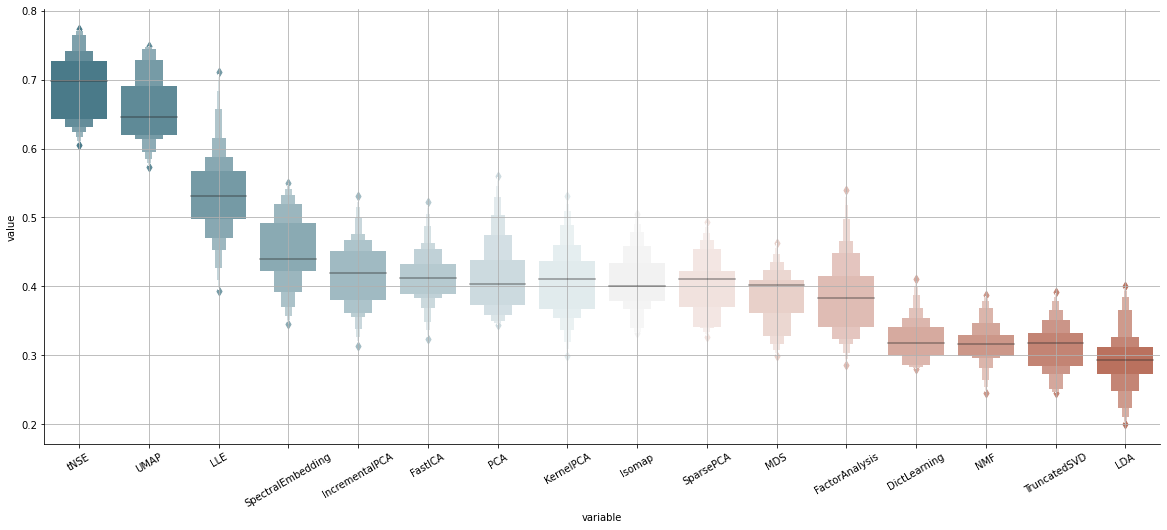

In [81]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.boxenplot(x = 'variable', y= 'value', data = pd.melt(gbdclf2), ax=ax, palette=sns.diverging_palette(220, 20, n=17))
plt.xticks(fontsize=10, rotation=30)
plt.grid()
sns.despine()

# plot dataset

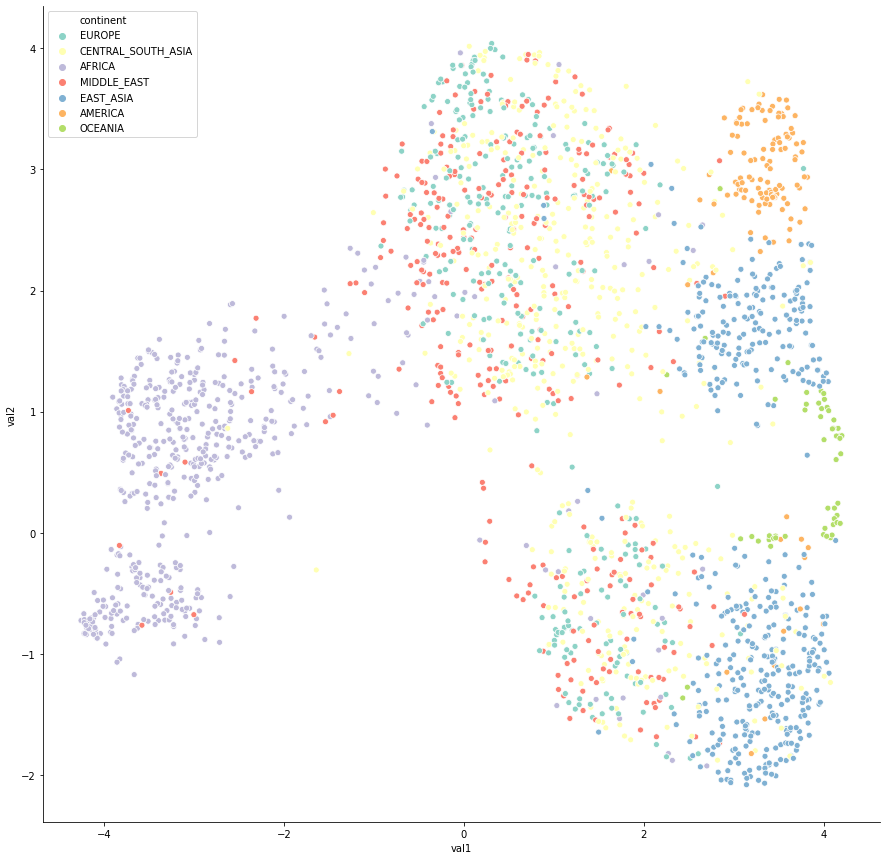

In [30]:
fig, ax = plt.subplots(figsize=(15, 15))

#datframe = pd.DataFrame(manifold.TSNE(n_components=2).fit_transform(df_maf_filtered.values), columns=['val1', 'val2'], index=indices)
datframe = pd.DataFrame(umap.UMAP().fit_transform(df_maf_filtered.values), columns=['val1', 'val2'], index=indices)
#datframe = pd.DataFrame(manifold.SpectralEmbedding(n_components=2).fit_transform(df_maf_filtered.values), columns=['val1', 'val2'], index=indices)




datframe['continent'] = Y
datframe['region']= indices[:,3]

sns.scatterplot(data = datframe, hue = 'continent', x= 'val1', y= 'val2', ax = ax, palette='Set3', vmax= 7, vmin=0)#, vmax= 7, vmin=0
sns.despine()


In [26]:
from matplotlib.colors import ListedColormap

In [27]:
pal2 = {1:"blue", 2:"goldenrod", 3:"mediumorchid", 4:"olivedrab", 5: 'violet', 6:'salmon' , 7:'aquamarine'}

In [28]:
pal = {"EUROPE":"blue", 'AFRICA':"goldenrod", 'EAST_ASIA':"mediumorchid", 'MIDDLE_EAST':"olivedrab", 'CENTRAL_SOUTH_ASIA': 'violet', 'AMERICA':'salmon' , 'OCEANIA':'aquamarine'}

In [29]:
def make_plot(method):
    #X_train, X_test, Y_train, Y_test = train_test_split(X, Y_edna, test_size=.3)
    choppeddf = df_maf_filtered.sample(frac=0.999)
    indices = np.array([np.array(x) for x in choppeddf.index.values])
    country_le = preprocessing.LabelEncoder()
    Y = indices[:, 4]
    Yt = country_le.fit_transform(Y)
    
    input_val = method.fit_transform(choppeddf.values)
    output_val = Yt
    clf = LGBMClassifier(num_leaves=4)
    #clf = ElasticNet(alpha=.1)
    #clf = MBKM(n_clusters=7)
    clf.fit(input_val, Yt)
    
    datframe = pd.DataFrame(input_val, columns=['val1', 'val2'], index=indices)
    datframe['continent'] = Y
    datframe['region']= indices[:,3]
    
    
    ranges = list(zip(np.array(datframe.min().values), np.array(datframe.max().values)))
    xranges = np.linspace(ranges[0][0], ranges[0][1], 100)
    yranges = np.linspace(ranges[1][0], ranges[1][1], 100)
    xx, yy = np.meshgrid(xranges,yranges)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(15, 15))
    
    sns.scatterplot(data = datframe, hue = 'continent', x= 'val1', y= 'val2', ax = ax, palette='Set3', vmax= 7, vmin=0)#, vmax= 7, vmin=0
    ax.contourf(xx, yy, Z, alpha=.2, cmap= matplotlib.cm.get_cmap('nipy_spectral'), vmax = 7, vmin= 0)# , vmax = 7, vmin= 0
    plt.xlim([ranges[0][0], ranges[0][1]])
    plt.ylim([ranges[1][0], ranges[1][1]])
    sns.despine()

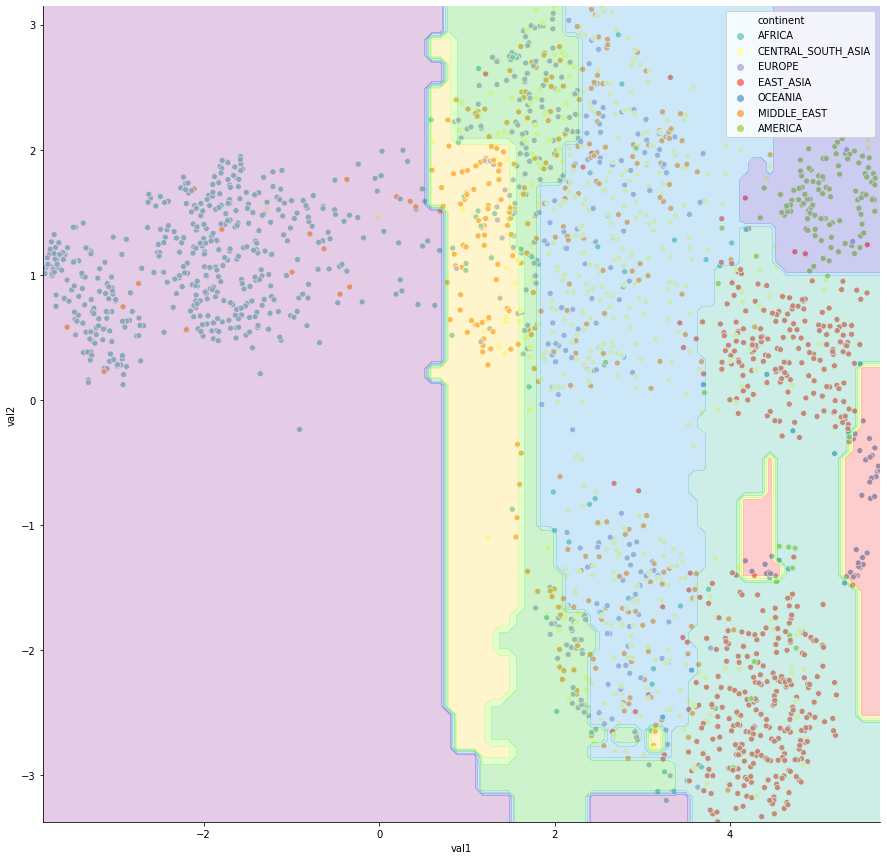

In [89]:
make_plot(umap.UMAP())

# Explain model using shap

In [28]:
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [29]:
from scipy.stats import randint as sp_randint
param_grid = {"max_depth": [100,30, None],
              "max_features": [10, 60],
              "min_samples_split": [10, 100, 300],
              "bootstrap": [True, False],
              "n_estimators": [50, 100, 300]}


In [30]:
from sklearn.neural_network import MLPClassifier

In [31]:
from sklearn.metrics import accuracy_score, classification_report

Accuracy score:
0.8329571106094809
                    precision    recall  f1-score   support

            AFRICA       0.94      0.96      0.95        99
           AMERICA       0.88      1.00      0.94        22
CENTRAL_SOUTH_ASIA       0.79      0.73      0.76       100
         EAST_ASIA       0.96      0.92      0.94        96
            EUROPE       0.63      0.67      0.65        55
       MIDDLE_EAST       0.68      0.72      0.70        60
           OCEANIA       1.00      1.00      1.00        11

          accuracy                           0.83       443
         macro avg       0.84      0.86      0.85       443
      weighted avg       0.84      0.83      0.83       443



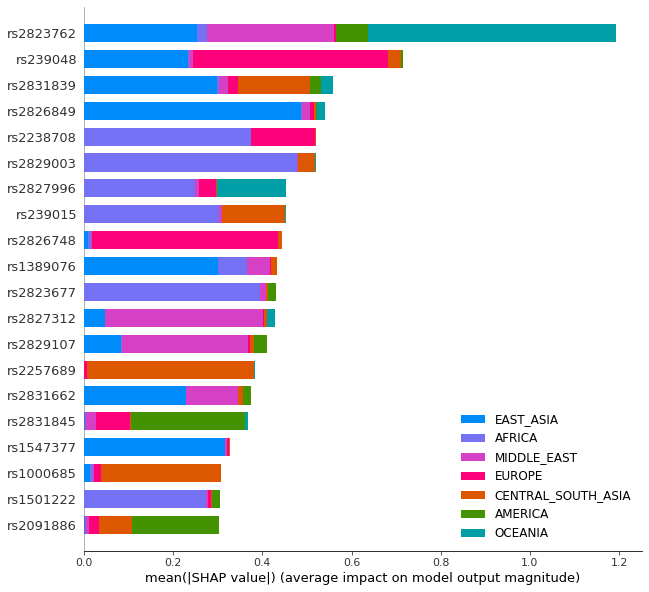

CPU times: user 58.1 s, sys: 584 ms, total: 58.7 s
Wall time: 21.1 s


In [32]:
%%time
import shap

X = df_maf_filtered.copy()
indices = np.array([np.array(x) for x in X.index.values])
#X = decomposition.PCA(n_components = 100).fit_transform(X)
country_le = preprocessing.LabelEncoder()
Y = indices[:, 4]
Yt = country_le.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Yt, test_size=.2, stratify = Yt, random_state = 63)

model = LGBMClassifier()#.set_params(**gridR.best_params_) num_leaves=200
#model = MLPClassifier(hidden_layer_sizes =200)
model.fit(X_train, Y_train)
print('Accuracy score:')
print(accuracy_score(model.predict(X_test), Y_test))
print(classification_report(model.predict(X_test), Y_test, target_names=country_le.inverse_transform(range(7))) )



fig, ax = plt.subplots(figsize=(10, 10))
#plt.xlim(-.05,.1)
shap.initjs()
explainer = shap.TreeExplainer(model)
#explainer = shap.DeepExplainer(model)

shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, auto_size_plot=False, max_display=20 ,class_names=country_le.inverse_transform(range(7)))
#rs2823762
#rs239048

In [33]:
#gridR = GridSearchCV(LGBMClassifier(),param_grid=param_grid,n_jobs=-1,cv=5,scoring= 'balanced_accuracy')
#gridR.fit(X_train, Y_train)
print('best parameters for lightGBM: ')
print(gridR.best_params_)
print(gridR.best_score_)

best parameters for lightGBM: 


NameError: name 'gridR' is not defined

In [34]:
country_le.inverse_transform(range(7))

array(['AFRICA', 'AMERICA', 'CENTRAL_SOUTH_ASIA', 'EAST_ASIA', 'EUROPE',
       'MIDDLE_EAST', 'OCEANIA'], dtype='<U22')

In [35]:
a = pd.DataFrame(abs(shap_values[2]), index = Yt, columns=X.columns).abs().mean().sort_values(ascending = False)

In [36]:
az = abs(a - a.mean())/a.std()

In [37]:
az[az> 2]

rs2257689    17.859756
rs1000685    12.743800
rs2836353     9.455708
rs183564      8.966784
rs2831839     7.496645
rs239015      6.556473
rs2822695     6.262675
rs995888      5.388588
rs2249028     5.049110
rs2251036     4.822201
rs2836344     4.770260
rs2829045     4.207702
rs2091886     3.320965
rs2823802     3.293808
rs2832089     3.290098
rs2830472     3.264560
rs2823704     3.187549
rs2823771     3.030034
rs239405      2.957673
rs2837304     2.955200
rs2822710     2.639164
rs2827987     2.538868
rs2091928     2.388902
rs2837181     2.079292
rs2244978     2.038382
rs2836315     2.000204
dtype: float64

In [38]:
all_shap = pd.DataFrame(sum([abs(v) for v in shap_values]), index = Yt, columns=X.columns).mean().sort_values(ascending = False)
all_shapZ = abs(all_shap - all_shap.mean())/all_shap.std()

In [39]:
all_shapZ[all_shapZ>2]

rs2823762    15.062133
rs239048      8.843391
rs2831839     6.793381
rs2826849     6.556523
rs2238708     6.311492
rs2829003     6.288441
rs2827996     5.430366
rs239015      5.426642
rs2826748     5.319724
rs1389076     5.158661
rs2823677     5.126919
rs2827312     5.113714
rs2829107     4.873866
rs2257689     4.506921
rs2831662     4.387857
rs2831845     4.307402
rs1547377     3.776281
rs1000685     3.529074
rs1501222     3.482999
rs2091886     3.472553
rs2828114     3.337413
rs1405760     3.280109
rs2835161     3.235383
rs183564      2.973353
rs151580      2.922759
rs2830444     2.661212
rs2836353     2.641179
rs2829140     2.465616
rs2828111     2.446362
rs2830472     2.433518
rs2205254     2.328710
rs2823820     2.299459
rs2836216     2.280545
rs2254038     2.168918
dtype: float64

In [45]:
glmm_data = df_maf_filtered.copy()
glmm_data['country'] = np.array([np.array(x) for x in glmm_data.index.values])[:, 4]
glmm_data_redux = glmm_data.reset_index()

In [46]:
formula = 'country ~ '
for site in glmm_data.columns.to_list()[:-1]:
    formula += site + '+'
formula = formula[:-1]

In [47]:
from statsmodels.formula.api import glm as glm_sm
import statsmodels.api as sm
md = glm_sm(formula, glmm_data_redux).fit()
md.summary()

ValueError: operands could not be broadcast together with shapes (2214,7) (2214,) 

In [48]:
formula


'country ~ rs2192160+rs2822441+rs2822475+rs434396+rs2822510+rs417214+rs2822518+rs2822545+rs2822554+rs1297119+rs2822562+rs2822573+rs2822577+rs2822578+rs2822580+rs2822581+rs2822584+rs2822586+rs2822588+rs2822589+rs2822590+rs2822593+rs2822594+rs2250102+rs2822596+rs2178907+rs2822598+rs2822599+rs2822600+rs2822603+rs2822606+rs2822612+rs2822614+rs2822615+rs2822616+rs2205254+rs722028+rs2223050+rs2822623+rs2822624+rs2014832+rs2822627+rs2822628+rs2822629+rs2822631+rs2822632+rs2822633+rs2822634+rs2822636+rs2822637+rs12479+rs2822642+rs2822643+rs2822644+rs2822645+rs1882881+rs2822649+rs2822653+rs2822654+rs1882884+rs2822655+rs2822657+rs2822659+rs2252199+rs2822660+rs2822661+rs2822668+rs2822672+rs723856+rs2822695+rs2822709+rs2822710+rs2822718+rs1980955+rs2822763+rs2823657+rs2823666+rs2823667+rs2823677+rs238946+rs2823704+rs183564+rs239048+rs239060+rs2823748+rs1389076+rs239075+rs239019+rs239021+rs239023+rs151580+rs239029+rs239030+rs239031+rs239032+rs2823751+rs239405+rs239015+rs2823756+rs1786015+rs1318181+

,level_0,level_1,level_2,level_3,level_4,level_5,level_6,rs2192160,rs2822441,rs2822475,...,rs2838485,rs2243348,rs2838488,rs2020943,rs1858665,rs2242954,rs2071135,rs2838494,rs2838503,country
0,1381,21,Adygei,Russia-Caucasus,EUROPE,955,F,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,EUROPE
1,1381,21,Adygei,Russia-Caucasus,EUROPE,955,F,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,EUROPE
2,1382,21,Adygei,Russia-Caucasus,EUROPE,956,F,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,EUROPE
3,1382,21,Adygei,Russia-Caucasus,EUROPE,956,F,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,EUROPE
4,1385,21,Adygei,Russia-Caucasus,EUROPE,959,M,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,EUROPE
5,1385,21,Adygei,Russia-Caucasus,EUROPE,959,M,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,EUROPE
6,1386,21,Adygei,Russia-Caucasus,EUROPE,960,F,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,EUROPE
7,1386,21,Adygei,Russia-Caucasus,EUROPE,960,F,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,EUROPE
8,1387,21,Adygei,Russia-Caucasus,EUROPE,962,F,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,EUROPE
9,1387,21,Adygei,Russia-Caucasus,EUROPE,962,F,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,EUROPE


In [ ]:
glm_sm

In [138]:
pal2 = {country_le.transform([key])[0]: pal2[key] for key in pal2.keys()}

In [157]:
pal2

{4: 'blue',
 0: 'goldenrod',
 3: 'mediumorchid',
 5: 'olivedrab',
 2: 'violet',
 1: 'salmon',
 6: 'aquamarine'}

In [56]:
glmm_data

rs2192160  rs2822441  rs2822475  \
1381 21  Adygei Russia-Caucasus EUROPE 955 F        0.0        0.0        1.0   
                                           F        0.0        1.0        1.0   
1382 21  Adygei Russia-Caucasus EUROPE 956 F        0.0        1.0        0.0   
                                           F        0.0        1.0        1.0   
1385 21  Adygei Russia-Caucasus EUROPE 959 M        0.0        1.0        0.0   
...                                                 ...        ...        ...   
942  465 Yoruba Nigeria         AFRICA 103 M        0.0        0.0        1.0   
943  465 Yoruba Nigeria         AFRICA 104 M        0.0        0.0        1.0   
                                           M        0.0        1.0        0.0   
944  465 Yoruba Nigeria         AFRICA 105 M        0.0        0.0        1.0   
                                           M        0.0        1.0        0.0   

                                              rs434396  rs2822510  rs417214  \
1381 21  Adygei Russia-Caucasus EUROPE 955 F       0.0        1.0       1.0   
                                           F       1.0        1.0       0.0   
1382 21  Adygei Russia-Caucasus EUROPE 956 F       0.0        1.0       1.0   
                                           F       1.0        1.0       0.0   
1385 21  Adygei Russia-Caucasus EUROPE 959 M       0.0        1.0       1.0   
...                                                ...        ...       ...   
942  465 Yoruba Nigeria         AFRICA 103 M       0.0        1.0       1.0   
943  465 Yoruba Nigeria         AFRICA 104 M       1.0        1.0       0.0   
                                           M       0.0        1.0       1.0   
944  465 Yoruba Nigeria         AFRICA 105 M       1.0        1.0       0.0   
                                           M       0.0        1.0       1.0   

                                              rs2822518  rs2822545  rs2822554  \
1381 21  Adygei Russia-Caucasus EUROPE 955 F        0.0        1.0        0.0   
                                           F        0.0        1.0        0.0   
1382 21  Adygei Russia-Caucasus EUROPE 956 F        0.0        1.0        0.0   
                                           F        0.0        1.0        0.0   
1385 21  Adygei Russia-Caucasus EUROPE 959 M        0.0        1.0        0.0   
...                                                 ...        ...        ...   
942  465 Yoruba Nigeria         AFRICA 103 M        0.0        1.0        0.0   
943  465 Yoruba Nigeria         AFRICA 104 M        0.0        1.0        1.0   
                                           M        0.0        1.0        0.0   
944  465 Yoruba Nigeria         AFRICA 105 M        0.0        1.0        1.0   
                                           M        0.0        1.0        0.0   

                                              rs1297119  ...  rs2838485  \
1381 21  Adygei Russia-Caucasus EUROPE 955 F        0.0  ...        1.0   
                                           F        1.0  ...        1.0   
1382 21  Adygei Russia-Caucasus EUROPE 956 F        1.0  ...        1.0   
                                           F        1.0  ...        1.0   
1385 21  Adygei Russia-Caucasus EUROPE 959 M        1.0  ...        0.0   
...                                                 ...  ...        ...   
942  465 Yoruba Nigeria         AFRICA 103 M        1.0  ...        1.0   
943  465 Yoruba Nigeria         AFRICA 104 M        0.0  ...        1.0   
                                           M        0.0  ...        0.0   
944  465 Yoruba Nigeria         AFRICA 105 M        0.0  ...        0.0   
                                           M        1.0  ...        0.0   

                                              rs2243348  rs2838488  rs2020943  \
1381 21  Adygei Russia-Caucasus EUROPE 955 F        0.0        0.0        0.0   
                                           F        0.0        0.0        0.0   
1382 21

In [153]:
pal2

{4: 'blue',
 0: 'goldenrod',
 3: 'mediumorchid',
 5: 'olivedrab',
 2: 'violet',
 1: 'salmon',
 6: 'aquamarine'}